In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /home/petpooja-1154/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


In [2]:
!pip install kagglehub

In [3]:
!pip install wordcloud
!pip install xgboost

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/petpooja-1154/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import pandas as pd
df = pd.read_csv("/home/petpooja-1154/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1/IMDB Dataset.csv")

In [6]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [7]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [8]:
df['length'] = df['review'].apply(len)

In [9]:
df.head()

,review,sentiment,length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


In [10]:
#random check

print(f"'review' column value: {df.iloc[10]['review']}")
print(f"'Length of review' : {len(df.iloc[10]['review'])}")
print(f"'length' column value: {df.iloc[10]['length']}")

'review' column value: Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn't find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"
'Length of review' : 578
'length' column value: 578


In [11]:
df.dtypes

review       object
sentiment    object
length        int64
dtype: object

In [12]:
print(f"sentiment count: \n{df['sentiment'].value_counts()}")

sentiment count: 
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [13]:
sent_1 = df[df['sentiment'] == "positive"].iloc[1]['review']
print(sent_1)

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.


In [14]:
sent_2 = df[df['sentiment'] == "negative"].iloc[1]['review']
print(sent_2)

This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such brilliance and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a huge success. As it is now, the show is just awful. I can't believe it's still on the air.


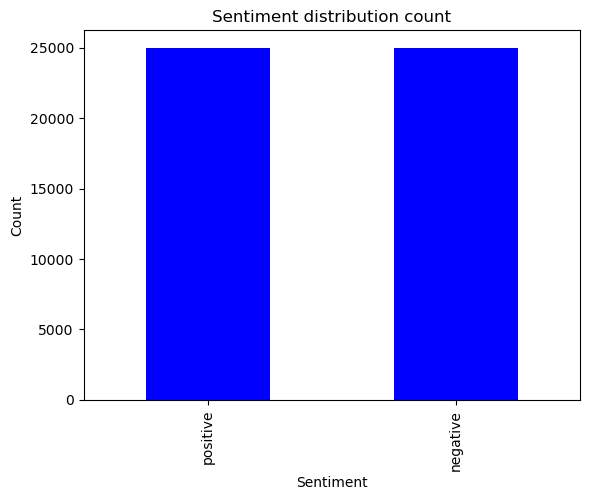

In [15]:
df['sentiment'].value_counts().plot.bar(color='blue')
plt.title('Sentiment distribution count')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [19]:
df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})

/tmp/ipykernel_44791/1176190499.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})


In [20]:
df.head()

,review,sentiment,length
0,One of the other reviewers has mentioned that ...,1,1761
1,A wonderful little production. <br /><br />The...,1,998
2,I thought this was a wonderful way to spend ti...,1,926
3,Basically there's a family where a little boy ...,0,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,1317


In [17]:
df['length'].describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review')]

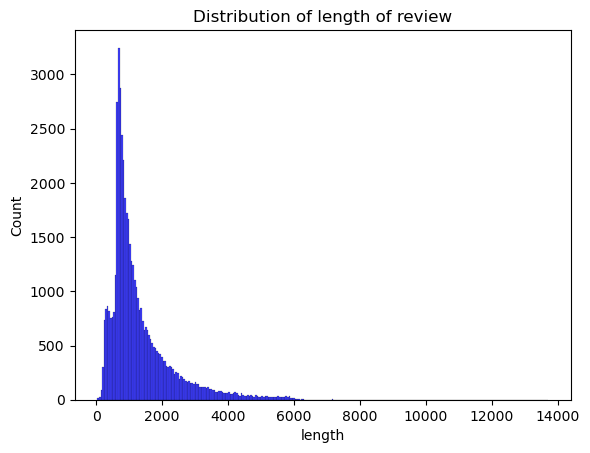

In [18]:
sns.histplot(df['length'], color='blue').set(title='Distribution of length of review')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

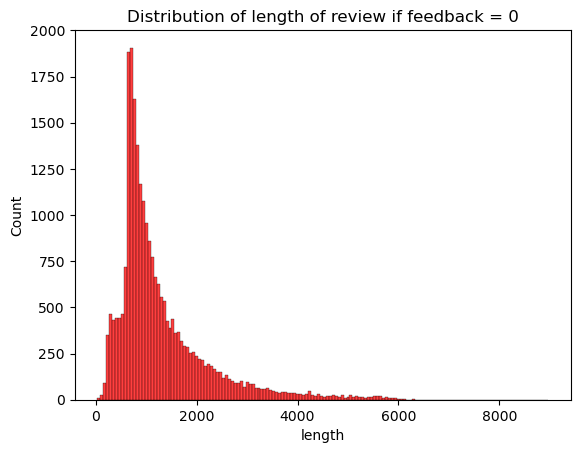

In [21]:
sns.histplot(df[df['sentiment']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

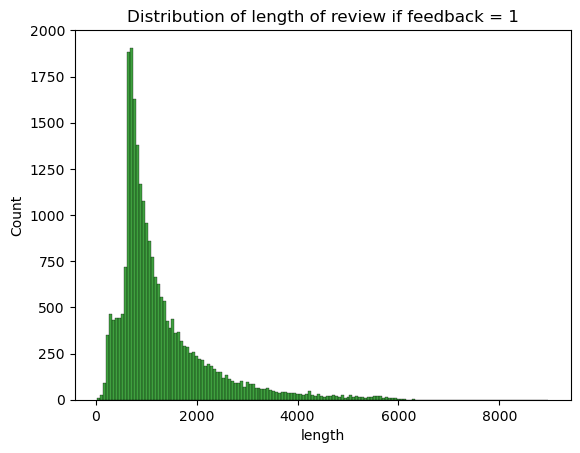

In [22]:
sns.histplot(df[df['sentiment']==0]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

In [23]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.review)

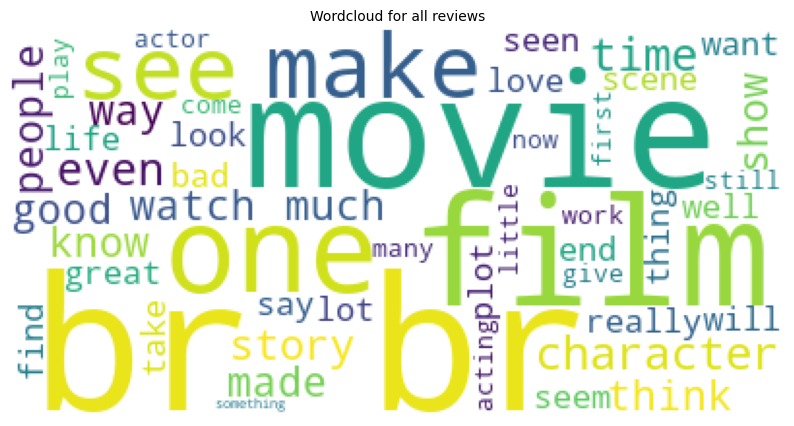

In [24]:
reviews = " ".join([review for review in df['review']])

wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title("Wordcloud for all reviews", fontsize=10)
plt.axis('off')
plt.show()

In [37]:
neg_reviews = " ".join([review for review in df[df['sentiment'] == 0]['review']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in df[df['sentiment'] == 1]['review']])
pos_reviews = pos_reviews.lower().split()

from collections import Counter

neg_counts = Counter(neg_reviews)
pos_counts = Counter(pos_reviews)

unique_negative = {word: count for word, count in neg_counts.items() if word not in pos_counts}
unique_negative = " ".join(unique_negative)
unique_positive = {word: count for word, count in pos_counts.items() if word not in neg_counts}
unique_positive = " ".join(unique_positive)

# unique_negative = [x for x in neg_reviews if x not in pos_reviews]
# unique_negative = " ".join(unique_negative)

# unique_positive = [x for x in pos_reviews if x not in neg_reviews]
# unique_positive = " ".join(unique_positive)

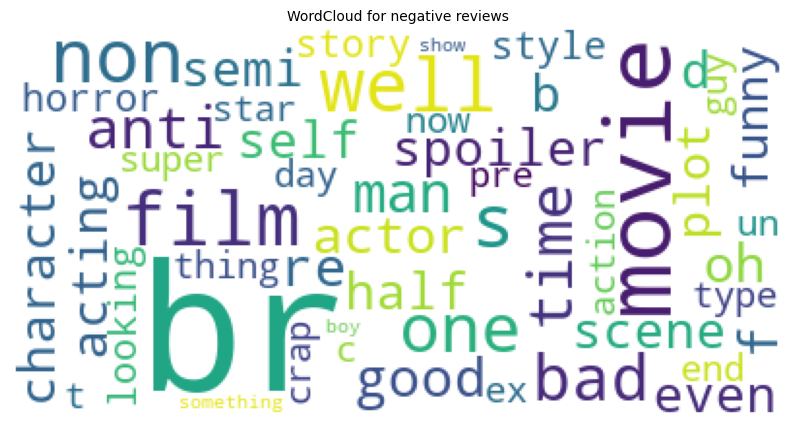

In [38]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('WordCloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

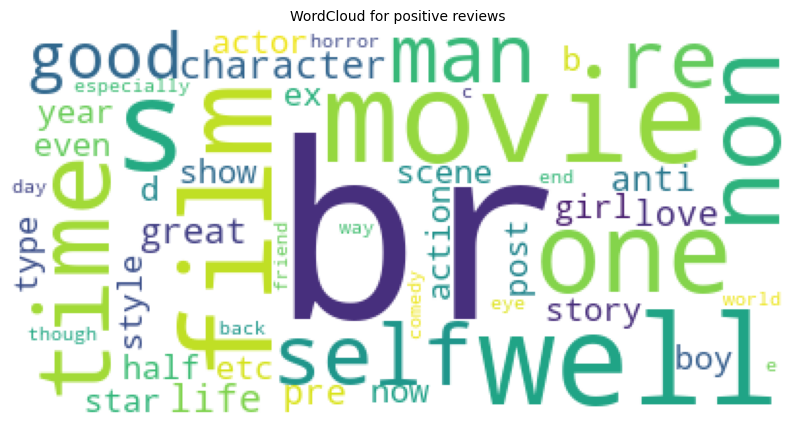

In [39]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('WordCloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

## Preprocessing and Modeling

In [40]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['review'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [41]:
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()
y = df['sentiment'].values

In [42]:
pickle.dump(cv, open('/home/petpooja-1154/Projects/Course/sentiment_analysis/countVectorizer.pkl', 'wb'))

In [44]:
print(f"X shape: {X.shape}")
print(f'y shape: {y.shape}')

X shape: (50000, 2500)
y shape: (50000,)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (35000, 2500)
y train: (35000,)
X test: (15000, 2500)
y test: (15000,)


In [46]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 118
X test max value: 160


In [47]:
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [49]:
pickle.dump(scaler, open('/home/petpooja-1154/Projects/Course/sentiment_analysis/scaler.pkl', 'wb'))

### Random Forest

In [51]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [52]:
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.8371333333333333


In [53]:
y_preds = model_rf.predict(X_test_scl)

In [54]:
cm = confusion_matrix(y_test, y_preds)

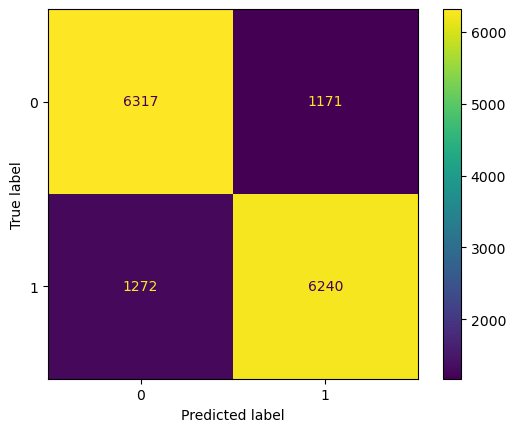

In [55]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [57]:
accuracies = cross_val_score(estimator=model_rf, X = X_train_scl, y=y_train, cv=10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.8432285714285715
Standard Variance : 0.006419422060578096


In [58]:
params = {
    "bootstrap": [True],
    "max_depth": [80,100],
    "min_samples_split": [8,12],
    "n_estimators": [100,300]
}

In [59]:
cv_object = StratifiedKFold(n_splits=2)

grid_search = GridSearchCV(estimator=model_rf, param_grid=params, cv= cv_object, verbose=0, return_train_score=True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [60]:
print("Best Parameter combination : {}".format(grid_search.best_params_))

Best Parameter combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 300}


In [61]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 99.72178571428572
Cross validation mean accuracy on test set : 84.35428571428571
Accuracy score for test set : 0.8371333333333333


### XgBoost

In [62]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [63]:
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9259142857142857
Testing Accuracy : 0.8534666666666667


In [64]:
y_preds = model_xgb.predict(X_test)

In [65]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[5821 1667]
 [ 770 6742]]


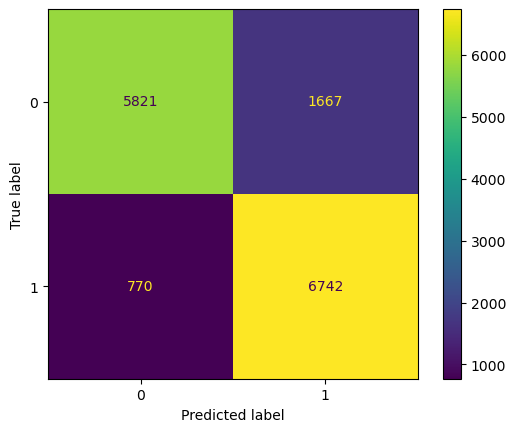

In [66]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [67]:
pickle.dump(model_xgb, open("/home/petpooja-1154/Projects/Course/sentiment_analysis/model_xgb.pkl", "wb"))

### Decision Tree Classifier

In [68]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [69]:
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.7172666666666667


In [70]:
y_preds = model_dt.predict(X_test)

In [71]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[3978 3510]
 [3352 4160]]


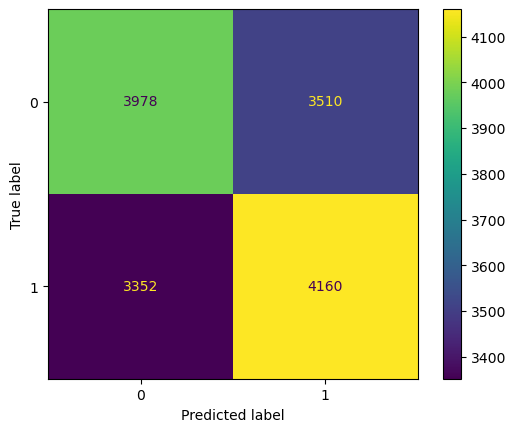

In [72]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_)
cm_display.plot()
plt.show()